# bivariate copula (bicop)


In [2]:
import sys
import platform
import torch
import torchvinecopulib as tvc
from torchvinecopulib.util import _EPS
import pyvinecopulib as pv
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python: 3.12.10 | packaged by conda-forge | (main, Apr 10 2025, 22:21:13) [GCC 13.3.0]
Platform: Linux-6.8.0-59-generic-x86_64-with-glibc2.39
PyTorch: 2.7.0+cu126
CUDA available: True


# Fitting a normal copula


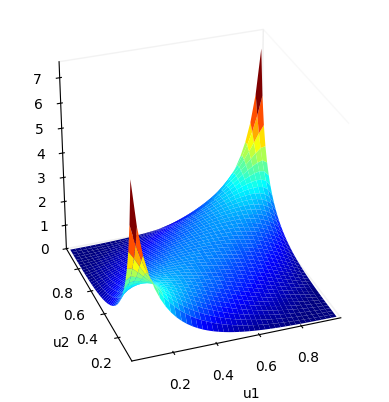

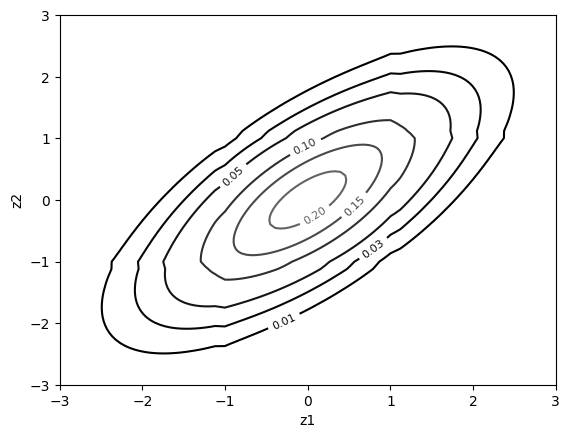

In [3]:
rho = 0.7
seeds = [0, 1, 2, 3, 4]
n = 1000
cop_true = pv.Bicop(
    family=pv.gaussian,
    parameters=np.array([[rho]]),
)
cop_true.plot()
cop_true.plot(type="contour", margin_type="norm")
U = cop_true.simulate(n, seeds=seeds)
U_tensor = torch.tensor(U, device=DEVICE)

## Using fast KDE


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='z1', ylabel='z2'>)

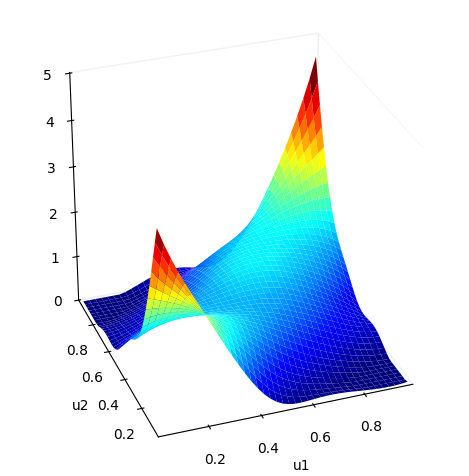

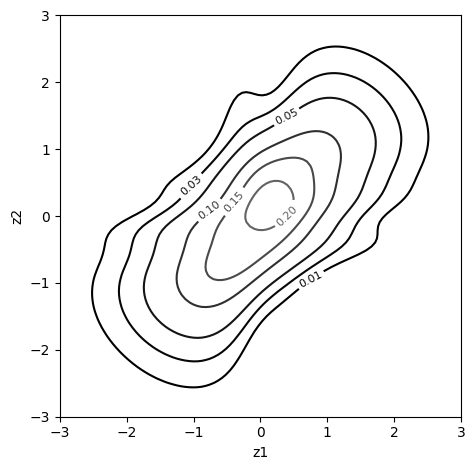

In [4]:
cop_fastkde = tvc.BiCop(
    num_step_grid=1024,
).to(DEVICE)
cop_fastkde.fit(U_tensor, num_obs_max=None, is_tll=False)
cop_fastkde.plot()
cop_fastkde.plot(plot_type="contour", margin_type="norm")

## Using TLL


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='z1', ylabel='z2'>)

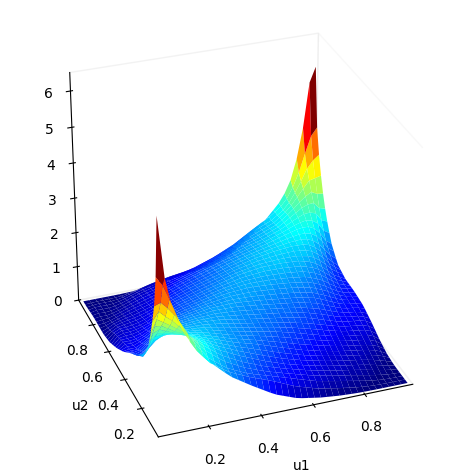

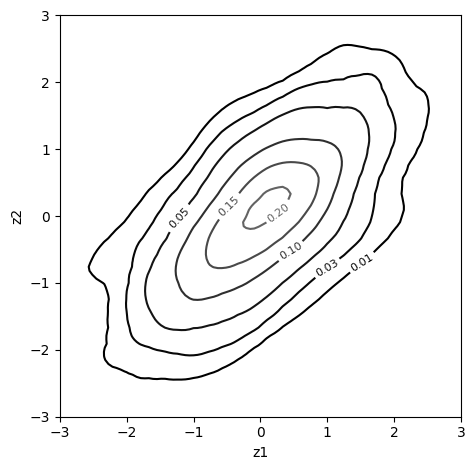

In [5]:
cop_tll = tvc.BiCop(
    num_step_grid=1024,
).to(DEVICE)
cop_tll.fit(U_tensor, num_obs_max=None, is_tll=True)
cop_tll.plot()
cop_tll.plot(plot_type="contour", margin_type="norm")

## Evaluate on grid


In [5]:
seeds = [5, 6, 7, 8, 9]
n_mc = 5000
u_sample = torch.tensor(cop_true.simulate(n_mc, seeds=seeds), device=DEVICE)
pdf_fastkde = cop_fastkde.pdf(u_sample).cpu().reshape(-1)
pdf_tll = cop_tll.pdf(u_sample).cpu().reshape(-1)
pdf_true = torch.from_numpy(cop_true.pdf(u_sample.cpu().numpy()))


def estimate_integrated_absolute_error(f, f_true):
    return torch.mean(torch.abs(f - f_true) / f_true)


iae_fastkde = estimate_integrated_absolute_error(pdf_fastkde, pdf_true)
iae_tll = estimate_integrated_absolute_error(pdf_tll, pdf_true)

print("IAE fastkde:", iae_fastkde.item())
print("IAE tll:", iae_tll.item())
print("IAE fastkde / IAE tll:", iae_fastkde.item() / iae_tll.item())

IAE fastkde: 0.12101888286772834
IAE tll: 0.10526007600960234
IAE fastkde / IAE tll: 1.149713048437172
